In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import napari
from PIL import Image
from matplotlib import pyplot as plt

from napari_convpaint.conv_paint import ConvPaintWidget
from napari_convpaint.conv_paint_utils import (Hookmodel, filter_image_multioutputs, get_features_current_layers, get_multiscale_features, train_classifier, predict_image)

from scribbles_creator import *

C:\Users\roman\AppData\Local\Temp\ipykernel_11412\1492712310.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\roman\anaconda3\envs\ilastik\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create predictions/segmentations with Convpaint on the cellpose dataset (wit self-created scribbles)

In [2]:
def selfpred_convpaint(image, labels, layer_list, scalings):
    # Ensure right shape and dimension order
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = np.moveaxis(image, -1, 0) # ConvPaint expects (C, H, W)
    # Define the model
    model = Hookmodel(model_name='vgg16')
    # Ensure the layers are given as a list
    if isinstance(layer_list, int):
        layer_list = [layer_list]
    # Read out the layer names
    all_layers = [key for key in model.module_dict.keys()]
    layers = [all_layers[i] for i in layer_list]
    # Register the hooks for the selected layers
    model.register_hooks(selected_layers=layers)
    # Get the features and targets
    features, targets = get_features_current_layers(
        model=model, image=image, annotations=labels, scalings=scalings,
        order=1, use_min_features=False, image_downsample=1)
    # Train the classifier
    random_forest = train_classifier(features, targets)
    # Predict on the image
    predicted = predict_image(
        image, model, random_forest, scalings=scalings,
        order=1, use_min_features=False, image_downsample=1)
    return predicted

In [3]:
def pred_cellpose_convpaint(folder_path, img_num, mode, bin, suff=False, layer_list=[0], scalings=[1,2], save_res=False, show_res=False):
    # Define the paths
    image_base = f"{folder_path}/{str(img_num).zfill(3)}"
    image_path = image_base + "_img.png"
    ground_truth_path = image_base + "_ground_truth.png"
    suff = "" if not suff else "_" + suff
    scribbles_path = image_base + f"_scribbles_{mode}_{bin}{suff}.png"    
    # Read the images
    ground_truth = np.array(Image.open(ground_truth_path))
    image = np.array(Image.open(image_path))
    labels = np.array(Image.open(scribbles_path))

    # Predict the image
    prediction = selfpred_convpaint(image, labels, layer_list, scalings)

    # Calculate stats
    acc = np.mean(ground_truth == prediction)
    perc_labelled = np.sum(labels>0) / (labels.shape[0] * labels.shape[1]) * 100

    if save_res:
        # Save the scribble annotation as an image
        pred_image = Image.fromarray(prediction)
        pred_path = image_path + f"_convpaint_{mode}_{bin}{suff}.png"
        pred_image.save(pred_path)

    if show_res:
        # Show the ground truth and the scribble annotation
        v = napari.Viewer()
        v.add_image(image)
        v.add_labels(ground_truth)
        v.add_labels(labels)
        v.add_labels(prediction)

    return prediction

In [6]:
folder_path = "./imgs/train"
all_suff = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"]
suff = all_suff[:5]
mode = "all"
layer_list = [0]
scalings = [1, 2]

for bin in [0.01]:#, 0.025, 0.05, 0.1, 0.25, 0.5, 1]:
    for img_num in range(0, 1):
        for s in suff:
            pred = pred_cellpose_convpaint(folder_path, img_num, mode, bin, s, layer_list, scalings, save_res=True, show_res=False)

## Analyse the created scribbles and segmentations (perc. labelled vs. acc.) from saved files

In [24]:
def analyse_cellpose_single_file(folder_path, img_num, mode, bin, suff=False, model="convpaint", show_res=False):
    # Define the paths
    image_base = f"{folder_path}/{str(img_num).zfill(3)}"
    image_path = image_base + "_img.png"
    ground_truth_path = image_base + "_ground_truth.png"
    suff = "" if not suff else "_" + suff
    scribbles_path = image_base + f"_scribbles_{mode}_{bin}{suff}.png"    
    pred_path = image_path + f"_{model}_{mode}_{bin}{suff}.png"
    # Read the images
    ground_truth = np.array(Image.open(ground_truth_path))
    image = np.array(Image.open(image_path))
    labels = np.array(Image.open(scribbles_path))
    prediction = np.array(Image.open(pred_path))

    # Calculate stats
    acc = np.mean(ground_truth == prediction)
    perc_labelled = np.sum(labels>0) / (labels.shape[0] * labels.shape[1]) * 100

    if show_res:
        # Show the ground truth and the scribble annotation
        v = napari.Viewer()
        v.add_image(image)
        v.add_labels(ground_truth)
        v.add_labels(labels)
        v.add_labels(prediction)

    res = pd.DataFrame({'group': f"{str(img_num)}_{mode}_{str(bin)}",
                        'image': image_path,
                        'ground truth': ground_truth_path,
                        'scribbles': scribbles_path,
                        'prediction': pred_path,
                        'mode': mode,
                        'bin': bin,
                        'perc. labelled': perc_labelled,
                        'accuracy': acc}, index=[0])
    
    return res
    

In [25]:
folder_path = "./imgs/train"
all_suff = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"]
suff = all_suff[:5]
mode = "all"

df = pd.DataFrame(columns=['group', 'image', 'ground truth', 'scribbles', 'prediction', 'mode', 'bin', 'perc. labelled', 'accuracy'])
for bin in [0.01]:#, 0.025, 0.05, 0.1, 0.25, 0.5, 1]:
    for img_num in range(0, 1):
        for s in suff:
            res = analyse_cellpose_single_file(folder_path, img_num, mode, bin, s, model="convpaint", show_res=False)
            df = pd.concat([df, res], ignore_index=True)

C:\Users\roman\AppData\Local\Temp\ipykernel_11412\3201782627.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, res], ignore_index=True)


In [26]:
df[:5]

,group,image,ground truth,scribbles,prediction,mode,bin,perc. labelled,accuracy
0,0_all_0.01,./imgs/train/000_img.png,./imgs/train/000_ground_truth.png,./imgs/train/000_scribbles_all_0.01_a.png,./imgs/train/000_img.png_convpaint_all_0.01_a.png,all,0.01,0.009179,0.950550
1,0_all_0.01,./imgs/train/000_img.png,./imgs/train/000_ground_truth.png,./imgs/train/000_scribbles_all_0.01_b.png,./imgs/train/000_img.png_convpaint_all_0.01_b.png,all,0.01,0.009179,0.897815
2,0_all_0.01,./imgs/train/000_img.png,./imgs/train/000_ground_truth.png,./imgs/train/000_scribbles_all_0.01_c.png,./imgs/train/000_img.png_convpaint_all_0.01_c.png,all,0.01,0.009179,0.690560
3,0_all_0.01,./imgs/train/000_img.png,./imgs/train/000_ground_truth.png,./imgs/train/000_scribbles_all_0.01_d.png,./imgs/train/000_img.png_convpaint_all_0.01_d.png,all,0.01,0.009179,0.908346
4,0_all_0.01,./imgs/train/000_img.png,./imgs/train/000_ground_truth.png,./imgs/train/000_scribbles_all_0.01_e.png,./imgs/train/000_img.png_convpaint_all_0.01_e.png,all,0.01,0.009179,0.891492


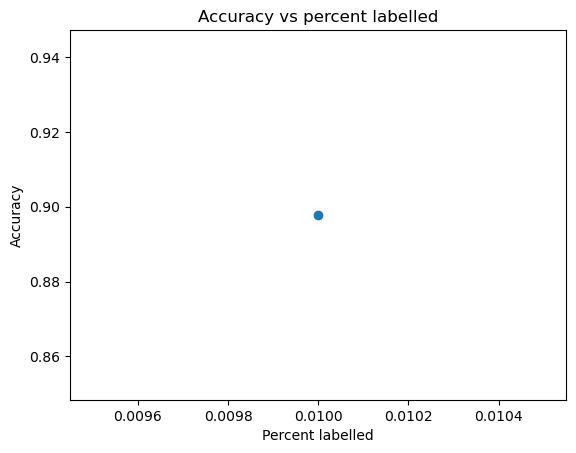

In [35]:
# Plot accuracy vs percent labelled
plt.figure()

# Scatterplot
# plt.scatter(df['perc. labelled'], df['accuracy'])
# plt.xlabel('Percent labelled')
# plt.ylabel('Accuracy')
# plt.title('Accuracy vs percent labelled')
# plt.show()

# Grouped plot
# For each picture, take the median; then for each bin, take the mean and standard deviation of the accuracy of all pictures and plot it versurs the percent labelled
df_grouped_img = df.groupby('group').agg({'bin': 'median', 'perc. labelled': 'median', 'accuracy': 'median'})
df_grouped_img
df_grouped_bin = df_grouped_img.groupby('bin').agg({'accuracy': ['mean', 'std'], 'perc. labelled': 'mean'}).reset_index()
plt.errorbar(df_grouped_bin['bin'], df_grouped_bin['accuracy']['mean'], yerr=df_grouped_bin['accuracy']['std'], fmt='o')
plt.xlabel('Percent labelled')
plt.ylabel('Accuracy')
plt.title('Accuracy vs percent labelled')
plt.show()
